# AlexNet(CNN)을 이용한 흉부 엑스레이 이상 탐지
## 1. 라이브러리 호출
## 2. 데이터 불러오기
## 3. 데이터 샘플링
## 4. 데이터 전처리
## 5. 모델링
## 6. 모델 평가

## 1. 라이브러리 호출

In [108]:
#Python 3.6.7 버전에서 작성 되었습니다.
#자료는 https://www.kaggle.com/nih-chest-xrays/data 에서 images_001.zip ~  images_005.zip까지
#다운로드 한 뒤에 샘플링을 거쳐 구성되었습니다.

#기본 라이브러리 묶음
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#이미지 핸들링 라이브러리
from PIL import Image
#모델 저장용 라이브러리
import joblib

In [ ]:
#OHE 라이브러리
from keras.utils import np_utils
#데이터셋 분리 
from sklearn.model_selection import train_test_split
#모델 평가
from sklearn.metrics import classification_report

In [ ]:
#딥러닝 모델 구성 관련 라이브러리 묶음
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

## 2. 데이터 불러오기

샘플로 받은 이미지 파일은 레이블이 없기 때문에 전체 이미지에 대한 메타 데이터를 갖고 있는 파일을 참고하여 샘플 데이터의 레이블을 찾아준다.

In [26]:
#X-Ray 사진들에 메타 데이터를 정리한 파일 읽어오기
total_img_info=pd.read_csv("./datasets/Data_Entry_2017(1).csv")

In [27]:
#이미지 파일의 파일명을 전부 불러온다.
file_list=os.listdir("./datasets/img/")

In [28]:
#모든 이미지 데이터에 대한 메타 데이터 중에서 이미지 파일의 이름만 가져온다.
total_list=total_img_info["Image Index"].values.tolist()

In [38]:
#모든 메타 데이터 중 현재 다운 받은 파일(images_001~005.zip)의 이름만 골라낸다.
dataset=set(total_list).intersection(set(file_list))

In [39]:
#리스트 형태로 바꿔준다.
dataset_list=list(dataset_list)

In [41]:
#샘플 데이터의 이름과 레이블로 구성된 데이터 프레임을 만들어준다.
df=total_img_info[total_img_info["Image Index"].isin(dataset_list)].copy()

In [43]:
#쉬운 컬럼명으로 변경한다.
df.columns=["Image","Label"]

In [44]:
#나중에 사용하기 위해 따로 저장한다.
df.to_csv("dataset.csv", index=False)

In [45]:
#레이블의 분포를 살펴본다.
df.Label.value_counts()

No Finding            25822
Infiltration           3075
Atelectasis            1763
Effusion               1554
Nodule                 1085
Pneumothorax            897
Mass                    782
Cardiomegaly            554
Pleural_Thickening      524
Consolidation           516
Fibrosis                429
Emphysema               400
Edema                   191
Pneumonia               126
Hernia                   55
Name: Label, dtype: int64

In [61]:
#상위 5개의 레이블만 가져온다.
df_pre=df[(df["Label"]=="No Finding")|(df["Label"]=="Infiltration")|(df["Label"]=="Atelectasis")|(df["Label"]=="Effusion")|(df["Label"]=="Nodule")].copy()

## 3. 데이터 샘플링

In [62]:
#층화 추출을 위한 함수
def stratified_sample_df(df, col, n_samples):
    """
    파이썬에는 층화 추출 함수가 없어 직접 만든 함수
    레이블 칼럼을 입력하면 레이블 종류별 값을 기준으로
    최소값에 해당하는 값만큼 각각의 레이블을 추출한다.
    """
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [63]:
#층화 추출
df_stry=stratified_sample_df(df_pre, "Label", 2000)

In [64]:
df_stry["Label"].value_counts()

No Finding      1085
Nodule          1085
Atelectasis     1085
Effusion        1085
Infiltration    1085
Name: Label, dtype: int64

## 4. 데이터 전처리

In [76]:
#파일 경로와 레이블 값만 따로 담아준다.
file_path=df_stry["Image"].values
labels=df_stry["Label"].values

In [77]:
labels[labels=="No Finding"]=0
labels[labels=="Nodule"]=1
labels[labels=="Atelectasis"]=2
labels[labels=="Effusion"]=3
labels[labels=="Infiltration"]=4

In [79]:
labels=labels.astype("int32")

In [89]:
img_list=[]

for i in range(len(df_stry)):
    #이미지를 불러온다.
    img_read =Image.open("./datasets/img/"+file_path[i])
    gray=img_read.convert(mode="RGB")
    print(i)
    #1024 이미지를 224 이미지로 축소한다.
    img_resize = gray.resize((224, 224), Image.ANTIALIAS)
    #이미지를 배열로 만들어준다.
    img_array = np.asarray(img_resize, dtype="float32")
    img_list.append(img_array)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345


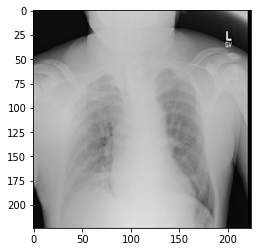

In [101]:
#이미지 확인
imgplot = plt.imshow(img_list[0]/255)
plt.show();

In [117]:
#레이블을 더미화 시켜준다.
dummy_y = np_utils.to_categorical(labels)

In [118]:
#훈련과 테스트 셋으로 데이터를 나눠준다.
x_train, x_test, y_train, y_test = train_test_split(img_list, dummy_y, test_size=0.3, random_state=523, stratify=labels)

In [119]:
#0과 1사이의 값으로 만들어준다.
x_train = np.array(x_train).reshape(len(x_train), 224*224*3).astype('float32') / 255.0
x_test = np.array(x_test).reshape(len(x_test), 224*224*3).astype('float32') / 255.0

In [120]:
#딥러닝 모델에 맞게 차원을 수정해준다.
x_tr=x_train.reshape(-1, 224,224,3)
x_te=x_test.reshape(-1, 224,224,3)

## 5. 모델링

In [149]:
# AlexNet 모델
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*1,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))

In [150]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_10 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_11 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 256)         0         
__________

In [151]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [152]:
# 모델 학습
hist = model.fit(x_tr, y_train, epochs=1000, batch_size=32, validation_split=.2)

Train on 3037 samples, validate on 760 samples
Epoch 1/1000
3037/3037 [==============================] - 13s 4ms/step - loss: 2.2254 - acc: 0.2338 - val_loss: 2.5110 - val_acc: 0.2461
Epoch 2/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.8736 - acc: 0.2460 - val_loss: 2.0501 - val_acc: 0.2697
Epoch 3/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.7914 - acc: 0.2591 - val_loss: 1.7616 - val_acc: 0.2803
Epoch 4/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.7472 - acc: 0.2730 - val_loss: 1.6175 - val_acc: 0.2921
Epoch 5/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.7101 - acc: 0.2730 - val_loss: 2.3542 - val_acc: 0.2303
Epoch 6/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.6652 - acc: 0.2937 - val_loss: 2.8303 - val_acc: 0.2553
Epoch 7/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.6358 - acc: 0.2931 - val_loss: 1.6042 - val_acc: 0.2961


3037/3037 [==============================] - 9s 3ms/step - loss: 0.1936 - acc: 0.9345 - val_loss: 3.8766 - val_acc: 0.3224
Epoch 61/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.1708 - acc: 0.9391 - val_loss: 3.5587 - val_acc: 0.2789
Epoch 62/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.2206 - acc: 0.9276 - val_loss: 3.8509 - val_acc: 0.3211
Epoch 63/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.1467 - acc: 0.9506 - val_loss: 3.7862 - val_acc: 0.3053
Epoch 64/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.1126 - acc: 0.9611 - val_loss: 4.0118 - val_acc: 0.2987
Epoch 65/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.1249 - acc: 0.9579 - val_loss: 4.1305 - val_acc: 0.3013
Epoch 66/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.1623 - acc: 0.9483 - val_loss: 3.9641 - val_acc: 0.3263
Epoch 67/1000
3037/3037 [==============================

Epoch 120/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0380 - acc: 0.9862 - val_loss: 4.9457 - val_acc: 0.3158
Epoch 121/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0345 - acc: 0.9878 - val_loss: 5.3379 - val_acc: 0.2987
Epoch 122/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0559 - acc: 0.9806 - val_loss: 5.1508 - val_acc: 0.3211
Epoch 123/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0903 - acc: 0.9681 - val_loss: 5.0112 - val_acc: 0.3145: 5s - loss - ET
Epoch 124/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0827 - acc: 0.9733 - val_loss: 4.9219 - val_acc: 0.2987
Epoch 125/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0515 - acc: 0.9839 - val_loss: 5.0954 - val_acc: 0.3066
Epoch 126/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0328 - acc: 0.9898 - val_loss: 5.0105 - val_acc: 0.3066
Epoch 127/1000
303

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0327 - acc: 0.9911 - val_loss: 5.2070 - val_acc: 0.2934
Epoch 180/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0150 - acc: 0.9944 - val_loss: 5.4106 - val_acc: 0.3053
Epoch 181/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0184 - acc: 0.9954 - val_loss: 4.8983 - val_acc: 0.3250
Epoch 182/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0322 - acc: 0.9888 - val_loss: 5.6311 - val_acc: 0.3053
Epoch 183/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0406 - acc: 0.9885 - val_loss: 5.0187 - val_acc: 0.3000
Epoch 184/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0328 - acc: 0.9875 - val_loss: 4.9931 - val_acc: 0.2974
Epoch 185/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0438 - acc: 0.9862 - val_loss: 5.1107 - val_acc: 0.3066
Epoch 186/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0093 - acc: 0.9967 - val_loss: 5.2019 - val_acc: 0.2776
Epoch 239/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0234 - acc: 0.9934 - val_loss: 5.0816 - val_acc: 0.3039
Epoch 240/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0593 - acc: 0.9829 - val_loss: 4.6871 - val_acc: 0.2776
Epoch 241/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0774 - acc: 0.9793 - val_loss: 5.1938 - val_acc: 0.3276
Epoch 242/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0448 - acc: 0.9832 - val_loss: 5.0185 - val_acc: 0.2974
Epoch 243/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0289 - acc: 0.9911 - val_loss: 4.7846 - val_acc: 0.2803
Epoch 244/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0129 - acc: 0.9957 - val_loss: 4.8788 - val_acc: 0.3132
Epoch 245/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0411 - acc: 0.9885 - val_loss: 4.6455 - val_acc: 0.3105
Epoch 298/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0512 - acc: 0.9835 - val_loss: 5.4785 - val_acc: 0.2934
Epoch 299/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0521 - acc: 0.9872 - val_loss: 5.3923 - val_acc: 0.2829
Epoch 300/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0253 - acc: 0.9934 - val_loss: 5.1685 - val_acc: 0.3039
Epoch 301/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0199 - acc: 0.9954 - val_loss: 5.2144 - val_acc: 0.2855
Epoch 302/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0117 - acc: 0.9967 - val_loss: 4.9501 - val_acc: 0.3079
Epoch 303/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0079 - acc: 0.9977 - val_loss: 5.2353 - val_acc: 0.2776
Epoch 304/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 5.0185 - val_acc: 0.3197
Epoch 357/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0088 - acc: 0.9987 - val_loss: 5.0598 - val_acc: 0.3105
Epoch 358/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0112 - acc: 0.9974 - val_loss: 5.0742 - val_acc: 0.3026
Epoch 359/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0017 - acc: 0.9997 - val_loss: 5.1448 - val_acc: 0.3039
Epoch 360/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 9.5395e-04 - acc: 1.0000 - val_loss: 5.1436 - val_acc: 0.3158
Epoch 361/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 5.8421e-04 - acc: 1.0000 - val_loss: 5.2028 - val_acc: 0.2987
Epoch 362/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0015 - acc: 0.9993 - val_loss: 5.1378 - val_acc: 0.3145
Epoch 363/1000
3037/3037 [===============

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0058 - acc: 0.9997 - val_loss: 4.8765 - val_acc: 0.3276
Epoch 416/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0086 - acc: 0.9990 - val_loss: 4.7954 - val_acc: 0.3118
Epoch 417/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0067 - acc: 0.9990 - val_loss: 4.8421 - val_acc: 0.3263
Epoch 418/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0059 - acc: 0.9997 - val_loss: 4.9668 - val_acc: 0.3342
Epoch 419/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0127 - acc: 0.9960 - val_loss: 5.2246 - val_acc: 0.3276
Epoch 420/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0327 - acc: 0.9908 - val_loss: 4.7203 - val_acc: 0.2816
Epoch 421/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0332 - acc: 0.9918 - val_loss: 4.9737 - val_acc: 0.3013
Epoch 422/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.3222 - val_acc: 0.3066
Epoch 475/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.3534 - val_acc: 0.3105
Epoch 476/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.3284 - val_acc: 0.3079
Epoch 477/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.4341 - val_acc: 0.3105
Epoch 478/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.4562 - val_acc: 0.3066
Epoch 479/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.4103 - val_acc: 0.3039
Epoch 480/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0053 - acc: 0.9997 - val_loss: 5.3815 - val_acc: 0.3053
Epoch 481/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0416 - acc: 0.9901 - val_loss: 4.9811 - val_acc: 0.3105
Epoch 534/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0538 - acc: 0.9868 - val_loss: 5.0331 - val_acc: 0.3158
Epoch 535/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0173 - acc: 0.9964 - val_loss: 5.1319 - val_acc: 0.3132
Epoch 536/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0161 - acc: 0.9980 - val_loss: 5.0408 - val_acc: 0.3145
Epoch 537/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0126 - acc: 0.9980 - val_loss: 4.9529 - val_acc: 0.2934
Epoch 538/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0087 - acc: 0.9984 - val_loss: 5.3058 - val_acc: 0.2816
Epoch 539/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0127 - acc: 0.9984 - val_loss: 5.2286 - val_acc: 0.2921
Epoch 540/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0264 - acc: 0.9937 - val_loss: 4.9831 - val_acc: 0.2961
Epoch 593/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0082 - acc: 0.9964 - val_loss: 4.9220 - val_acc: 0.3224
Epoch 594/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0023 - acc: 0.9997 - val_loss: 4.8636 - val_acc: 0.3197
Epoch 595/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 9.8038e-04 - acc: 1.0000 - val_loss: 4.7731 - val_acc: 0.3026
Epoch 596/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 9.3242e-04 - acc: 1.0000 - val_loss: 4.8974 - val_acc: 0.3224
Epoch 597/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 4.2236e-04 - acc: 1.0000 - val_loss: 4.8994 - val_acc: 0.3171loss: 4.4108e-04 
Epoch 598/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 2.7051e-04 - acc: 1.0000 - val_loss: 4.9150 - val_acc: 0.3171
Epoch 599/1000
3

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 5.1218 - val_acc: 0.2816
Epoch 651/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 5.0740 - val_acc: 0.2816
Epoch 652/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 5.3831e-04 - acc: 1.0000 - val_loss: 5.1816 - val_acc: 0.2816
Epoch 653/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 6.6803e-04 - acc: 1.0000 - val_loss: 5.1856 - val_acc: 0.2947
Epoch 654/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 3.7691e-04 - acc: 1.0000 - val_loss: 5.1807 - val_acc: 0.2803
Epoch 655/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.6861e-04 - acc: 1.0000 - val_loss: 5.1864 - val_acc: 0.2829
Epoch 656/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 1.9712e-04 - acc: 1.0000 - val_loss: 5.1613 - val_acc: 0.2816
Epoch 657/1000
3037/3037 [===

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0132 - acc: 0.9977 - val_loss: 5.1574 - val_acc: 0.3289
Epoch 709/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0123 - acc: 0.9970 - val_loss: 5.4538 - val_acc: 0.2947
Epoch 710/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0163 - acc: 0.9964 - val_loss: 5.4801 - val_acc: 0.2921
Epoch 711/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0115 - acc: 0.9977 - val_loss: 5.5020 - val_acc: 0.2947
Epoch 712/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0095 - acc: 0.9984 - val_loss: 5.6097 - val_acc: 0.2961
Epoch 713/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0117 - acc: 0.9980 - val_loss: 5.6258 - val_acc: 0.3118
Epoch 714/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0094 - acc: 0.9984 - val_loss: 5.6381 - val_acc: 0.3000
Epoch 715/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0061 - acc: 0.9997 - val_loss: 5.6916 - val_acc: 0.2987
Epoch 768/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0060 - acc: 0.9993 - val_loss: 5.6959 - val_acc: 0.2961
Epoch 769/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0080 - acc: 0.9987 - val_loss: 5.4747 - val_acc: 0.3118
Epoch 770/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0744 - acc: 0.9819 - val_loss: 5.3462 - val_acc: 0.2803
Epoch 771/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0332 - acc: 0.9934 - val_loss: 5.3297 - val_acc: 0.2974
Epoch 772/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0225 - acc: 0.9960 - val_loss: 4.9728 - val_acc: 0.3079
Epoch 773/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0228 - acc: 0.9967 - val_loss: 5.1914 - val_acc: 0.2987
Epoch 774/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0377 - acc: 0.9924 - val_loss: 5.5207 - val_acc: 0.3013
Epoch 827/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0196 - acc: 0.9960 - val_loss: 5.7448 - val_acc: 0.2895
Epoch 828/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0092 - acc: 0.9980 - val_loss: 5.4890 - val_acc: 0.2908
Epoch 829/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 5.4649 - val_acc: 0.2855
Epoch 830/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0027 - acc: 0.9990 - val_loss: 5.4401 - val_acc: 0.3026
Epoch 831/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0015 - acc: 0.9990 - val_loss: 5.5859 - val_acc: 0.2868
Epoch 832/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0027 - acc: 0.9997 - val_loss: 5.5174 - val_acc: 0.2921
Epoch 833/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0054 - acc: 0.9997 - val_loss: 5.1732 - val_acc: 0.3066
Epoch 886/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0062 - acc: 0.9993 - val_loss: 5.2121 - val_acc: 0.2895
Epoch 887/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 5.2063 - val_acc: 0.3000
Epoch 888/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0055 - acc: 0.9997 - val_loss: 5.1373 - val_acc: 0.2987
Epoch 889/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0055 - acc: 0.9997 - val_loss: 5.1185 - val_acc: 0.2974
Epoch 890/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0054 - acc: 0.9997 - val_loss: 5.1113 - val_acc: 0.3039
Epoch 891/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0055 - acc: 0.9997 - val_loss: 5.0846 - val_acc: 0.3013
Epoch 892/1000
3037/3037 [=======================

3037/3037 [==============================] - 9s 3ms/step - loss: 0.0165 - acc: 0.9990 - val_loss: 5.6629 - val_acc: 0.2947
Epoch 945/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0162 - acc: 0.9990 - val_loss: 5.6188 - val_acc: 0.2934
Epoch 946/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0163 - acc: 0.9990 - val_loss: 5.5776 - val_acc: 0.3066
Epoch 947/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0163 - acc: 0.9990 - val_loss: 5.4747 - val_acc: 0.3184
Epoch 948/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0186 - acc: 0.9984 - val_loss: 5.3087 - val_acc: 0.3118
Epoch 949/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0173 - acc: 0.9984 - val_loss: 5.5390 - val_acc: 0.3197
Epoch 950/1000
3037/3037 [==============================] - 9s 3ms/step - loss: 0.0208 - acc: 0.9980 - val_loss: 5.7768 - val_acc: 0.3079
Epoch 951/1000
3037/3037 [=======================

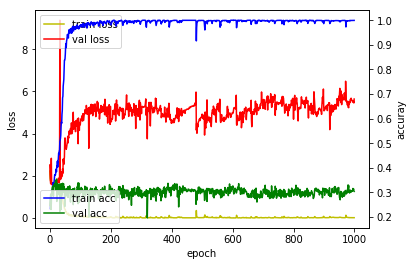

In [153]:
# 모델 학습과정 살펴보기
%matplotlib inline

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')


acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 6. 모델 평가

In [154]:
#모델 평가하기
loss_and_metrics = model.evaluate(x_te, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1628/1628 [==============================] - 2s 1ms/step
## evaluation loss and_metrics ##
[5.5423081301939865, 0.3255528254796012]


In [155]:
#모델을 이용하여 흉부사진을 분류한다.
y_pred=model.predict_classes(x_te)

In [156]:
#결과 값을 OHE 해야 비교해볼 수 있다.
dummy_pred = np_utils.to_categorical(y_pred)

In [157]:
#F1 스코어를 살펴본다.
print(classification_report(y_test, dummy_pred ))

              precision    recall  f1-score   support

           0       0.29      0.24      0.26       326
           1       0.32      0.27      0.29       325
           2       0.34      0.47      0.39       326
           3       0.38      0.31      0.34       326
           4       0.30      0.34      0.32       325

   micro avg       0.33      0.33      0.33      1628
   macro avg       0.33      0.33      0.32      1628
weighted avg       0.33      0.33      0.32      1628
 samples avg       0.33      0.33      0.33      1628



In [158]:
# 모델을 저장한다.
filename = 'alexnet_cnn.sav'
joblib.dump(model, filename)

['alexnet_cnn.sav']

In [148]:
#혹시 반복하게 된다면 가중치 리셋을 위한 코드
#model.reset_states()